# Project 2

## Topic : Stereo reconstruction and Non-linear optimization

#### Instructions
<ul>
    <li> The second project of the course is designed to get you familiar with stereo reconstruction, and non-linear optimization </li>
    <li> Use python for this project. PILLOW and OpenCV are permitted for image I/O. </li>
    <li> Submit this notebook as a zipped file on moodle. The format should be $<$team_id$>$_$<$team_ name$>$.zip. Both members have to submit this zip file. </li>
    <li> A seperate report is not needed if you're coding in the notebook itself. Please provide adequate descriptions of the approaches you've taken. Also mention work distribution for the two members. </li>
    <li> Refer to the late day policy. Start early </li> 
    <li> Download data from here: https://iiitaphyd-my.sharepoint.com/:f:/g/personal/aryan_sakaria_students_iiit_ac_in/Er5C7351IAlFsvwHUesFeSQBQtlSiAS7AORSEJT2qH_8_w?e=ol98k9  </li>
</ul>

----
### PART 1: Stereo dense reconstruction

3-D point clouds are very useful in robotics for several tasks such as object detection, motion estimation (3D-3D matching or 3D-2D matching), SLAM, and other forms of scene understanding.  Stereo camerasprovide  us  with  a  convenient  way  to  generate  dense  point  clouds.Densehere,  in  contrast  tosparse,means all the image points are used for the reconstruction.  In this part of the assignment you will begenerating a dense 3D point cloud reconstruction of a scene from stereo images.

#### Procedure: 

<ol>
    <li> Generate a disparity map for each stereo pair.  Use OpenCV (e.g.  StereoSGBM) for this.  Notethat the images provided are already rectified and undistorted. </li>
    <li> Then, using the camera parameters and baseline information generate colored point clouds fromeach disparity map.  Some points will have invalid disparity values, so ignore them.  Use [Open3D]for storing your point clouds. </li>
    <li> Register (or transform) all the generated point clouds into your world frame by using the providedground truth poses. </li>
    <li> Visualize the registered point cloud data, in color.  Use Open3D for this </li>
</ol>
    

In [8]:
#import libraries:
import numpy as np 
# from sklearn.preprocessing import normalize #normalizing gives better results. Experiment with this
import cv2
from matplotlib import pyplot as plt
import open3d as o3d

In [9]:
def read_transformations(filename):
    f = open(filename, 'r')
    pose_data = np.loadtxt(f)
    transformation_list = pose_data.reshape(len(pose_data),3,4)
    return transformation_list

Provide explanation in this cell: 


In [10]:
def project_points_to_world(points,pose):
    points = (pose @ points.T).T
    return points

def getParallaxMap(disparity):
    h,w = disparity.shape
    disparity_map = []
    for i in range(h):
        for j in range(w):
            disparity_map.append([j,i,disparity[i,j],1])
    return np.array(disparity_map)

def reprojectImageTo3d(disparity_map,Q):
    points = []
    for dis in disparity_map:
        point = Q @ dis
        points.append(point)
    return np.array(points)

In [11]:
ground_truth_file = 'poses.txt'
poses = read_transformations(ground_truth_file)
K = np.array([[7.070912e+02, 0.000000e+00, 6.018873e+02],
              [0.000000e+00, 7.070912e+02, 1.831104e+02],
              [0.000000e+00, 0.000000e+00, 1.000000e+00]])
f = K[0,0]
b = 0.53790448812

In [12]:
pcd = o3d.geometry.PointCloud()
combined_pcd = o3d.geometry.PointCloud()

def find_disparity(imageL,imageR):
    window_size = 5
    min_disp = -39
    num_disp = 144
    stereo = cv2.StereoSGBM_create(minDisparity = min_disp,
        numDisparities = num_disp,
        disp12MaxDiff = 1,
        blockSize=5,
        P1= 8*3* window_size**2,
        P2= 32*3*window_size**2,
        uniquenessRatio = 10,
        speckleWindowSize = 100,
        speckleRange = 32,
        preFilterCap= 63
        )
    disparity = stereo.compute(imageL, imageR).astype(np.float32)/64.0
    disparity = (disparity-min_disp)/num_disp
    return disparity

for i in range(21):
    img_loc = "/0000000"+str(460+i)+".png"
    l_img = "./img2"+img_loc
    r_img = "./img3"+img_loc
    print ("Comparing: ",l_img,r_img)
    imgL = cv2.imread(l_img)
    imgR = cv2.imread(r_img)
    disparity = find_disparity(imgL,imgR)
    h,w = disparity.shape
    Q = np.array([[ 1,  0,  0, -w/2],
                  [ 0,  -1,  0, h/2],
                  [ 0,  0,  0, f],
                  [ 0,  0,  1/b, 0]])
    disparity_map = getParallaxMap(disparity)
    point_cloud = reprojectImageTo3d(disparity_map,Q)
    colors = cv2.cvtColor(imgL, cv2.COLOR_BGR2RGB)
    mask = (disparity >= disparity.min())
    colors = colors[mask]
    colors = colors/255
    cloud_colors = np.array(colors);
    point_cloud[:,0] = point_cloud[:,0]/point_cloud[:,3]
    point_cloud[:,1] = point_cloud[:,1]/point_cloud[:,3] 
    point_cloud[:,2] = point_cloud[:,2]/point_cloud[:,3]
    point_cloud[:,3] = point_cloud[:,3]/point_cloud[:,3]
    point_cloud = project_points_to_world(point_cloud,poses[i]);
    mask = ((-1500 <= point_cloud[:,1]) & (point_cloud[:,1] < 1500) &
        (-1500 <= point_cloud[:,2]) & (point_cloud[:,2] < 1500) &
        (-1500 <= point_cloud[:,0]) & (point_cloud[:,0] < 1500))

    point_cloud = point_cloud[mask]
    cloud_colors = cloud_colors[mask]
    point_cloud[:,0] *= -1
    pcd.points = o3d.utility.Vector3dVector(point_cloud)
    pcd.colors = o3d.utility.Vector3dVector(cloud_colors)
    combined_pcd = combined_pcd + pcd
    
    
o3d.io.write_point_cloud("colored_op.pcd", combined_pcd)

Comparing:  ./img2/0000000460.png ./img3/0000000460.png
Comparing:  ./img2/0000000461.png ./img3/0000000461.png
Comparing:  ./img2/0000000462.png ./img3/0000000462.png
Comparing:  ./img2/0000000463.png ./img3/0000000463.png
Comparing:  ./img2/0000000464.png ./img3/0000000464.png
Comparing:  ./img2/0000000465.png ./img3/0000000465.png
Comparing:  ./img2/0000000466.png ./img3/0000000466.png
Comparing:  ./img2/0000000467.png ./img3/0000000467.png
Comparing:  ./img2/0000000468.png ./img3/0000000468.png
Comparing:  ./img2/0000000469.png ./img3/0000000469.png
Comparing:  ./img2/0000000470.png ./img3/0000000470.png
Comparing:  ./img2/0000000471.png ./img3/0000000471.png
Comparing:  ./img2/0000000472.png ./img3/0000000472.png
Comparing:  ./img2/0000000473.png ./img3/0000000473.png
Comparing:  ./img2/0000000474.png ./img3/0000000474.png
Comparing:  ./img2/0000000475.png ./img3/0000000475.png
Comparing:  ./img2/0000000476.png ./img3/0000000476.png
Comparing:  ./img2/0000000477.png ./img3/0000000

True

In [13]:
output = o3d.io.read_point_cloud("colored_op.pcd")

In [14]:
o3d.visualization.draw_geometries([output])

----
### PART 2: Motion estimation using iterative PnP

Using the generated reconstruction from the previous part, synthesize a new image taken by a virtualmonocular camera fixed at any arbitrary position and orientation.  Your task in this part is to recover this pose using an iterative Perspective-from-n-Points (PnP) algorithm. 

#### Procedure: 

<ol>
    <li> Obtain a set of 2D-3D correspondences between the the image and the point cloud.  Since hereyou’re generating the image, this should be easy to obtain. </li>
    <li> For this set of correspondences compute the total reprojection error c= $\sum_{i} ‖x_i−P_{k}X_i‖^2 $    where $P_{k}= K[R_{k}|t_{k}]$, $X_{i}$ is the 3D point in the world frame, $x_{i}$ is its corresponding projection. </li>
    <li> Solve for the pose $T_{k}$ that minimizes this non-linear reprojection error using a Gauss-Newton (GN)scheme.  Recall that in GN we start with some initial estimated value $x_{o}$ and iteratively refine the estimate using $x_{1}$= $∆x+x_0$, where $∆x$ is obtained by solving the normal equations $J^{T}J∆x$= -$J^{T}e$, until convergence.The main steps in this scheme are computing the corresponding Jacobians and updating the estimates correctly.  For our problem,  use a 12×1 vector parameterization for $T_{k}$(the top 3×4submatrix).  Run the optimization for different choices of initialization and report your observations. </li>
</ol>

In [15]:
pcd_pts = np.asarray(output.points)
points_h=np.hstack((pcd_pts,np.ones((pcd_pts.shape[0],1))))
points_h = points_h[0::10,:]
colors = output.colors
print (points_h.shape)

(703447, 4)


In [16]:
T_gt = np.eye(4,4)
T_gt[:3,:4] = poses[0]
T_gt = np.linalg.inv(T_gt)
P_gt = K@ T_gt[:3,:4]
img_h = (P_gt@ points_h.T).T

In [17]:
def DLT(x,X):
    x[:,0] = x[:,0]/x[:,2]
    x[:,1] = x[:,1]/x[:,2]
    L = len(X);
    zeros = np.zeros((L,4))
    A = (np.vstack((x[:,0]*X[:,0],np.vstack((x[:,0]*X[:,1],np.vstack((x[:,0]*X[:,2],x[:,0]*X[:,3]))))))).T
    B = (np.vstack((x[:,1]*X[:,0],np.vstack((x[:,1]*X[:,1],np.vstack((x[:,1]*X[:,2],x[:,1]*X[:,3]))))))).T
    Ax = np.hstack((-X,np.hstack((zeros,A))))
    Ay = np.hstack((zeros,np.hstack((-X,B))))    
    M = np.vstack((Ax,Ay))
    U,D,VT = np.linalg.svd(M);
    P = np.array(VT[-1]).reshape(3,4);
    P = P/P[-1,-1]
    return P


def Jacobian(x,X):
    L = len(X)
    scl = x[:,2]
    X[:,0] = X[:,0]/scl
    X[:,1] = X[:,1]/scl
    X[:,2] = X[:,2]/scl
    X[:,3] = X[:,3]/scl
    x[:,0] = x[:,0]/scl
    x[:,1] = x[:,1]/scl
    zeros = np.zeros((L,4))
    A = (np.vstack((x[:,0]*X[:,0],np.vstack((x[:,0]*X[:,1],np.vstack((x[:,0]*X[:,2],x[:,0]*X[:,3]))))))).T
    B = (np.vstack((x[:,1]*X[:,0],np.vstack((x[:,1]*X[:,1],np.vstack((x[:,1]*X[:,2],x[:,1]*X[:,3]))))))).T
    J_x = np.hstack((-X,np.hstack((zeros,A))))
    J_y = np.hstack((zeros,np.hstack((-X,B))))
    J = np.vstack((J_x,J_y))
    return J

def GN(P,x_gt,X,N,tol): 
    Cost = np.zeros(N)
    for i in range(N):
        x = (P@ X.T).T
        A = x_gt[:,0]/x_gt[:,2] - x[:,0]/x[:,2]
        B = x_gt[:,1]/x_gt[:,2] - x[:,1]/x[:,2]
        res = (np.hstack((A,B))).reshape(-1,1)
        Cost[i] = (res.T@res/2/len(X)).item(0)
        if (i%5==4 or i==0):
            print("Cost at iter ",i+1,"=",Cost[i])
        J = Jacobian(x,X)
        H = J.T@J
        update = np.linalg.inv(H)@J.T@res;
        P = (P.reshape(12,1) - update).reshape(3,4);
        if(np.linalg.norm(update)<tol):
            print("GN converged at iter ",i+1)
            break
    return P, Cost, i

In [18]:
P_init = DLT(img_h[:10,:],points_h[:10,:])
print("P_GT = ")
print(P_gt)

P_GT = 
[[-8.90929517e+02  5.38387637e+01 -2.56109933e+02 -1.53083396e+05]
 [-3.68165080e+01  7.13415332e+02 -1.52284250e+02  2.00006057e+01]
 [-4.11338164e-01  4.10740947e-02 -9.10556891e-01 -2.77880277e+01]]


In [19]:
print("\nInitialisation for P = ")
print(P_init)
print(P_gt[-1,-1]*P_init)


Initialisation for P = 
[[ 3.20616341e+01 -1.93747852e+00  9.21655800e+00  5.50896991e+03]
 [ 1.32490589e+00 -2.56734829e+01  5.48021064e+00 -7.19790961e-01]
 [ 1.48027138e-02 -1.47812755e-03  3.27679579e-02  1.00000000e+00]]
[[-8.90929578e+02  5.38387069e+01 -2.56109969e+02 -1.53083409e+05]
 [-3.68165217e+01  7.13415455e+02 -1.52284245e+02  2.00015712e+01]
 [-4.11338221e-01  4.10742494e-02 -9.10556924e-01 -2.77880277e+01]]



T_GT = 
[[-9.09854768e-01  4.11782636e-02  4.12878417e-01 -1.92843773e+02]
 [ 5.44537786e-02  9.98307203e-01  2.04332712e-02  7.22435448e+00]
 [-4.11338164e-01  4.10740947e-02 -9.10556891e-01 -2.77880277e+01]]
Cost at iter  1 = 22808567747.730625
Cost at iter  5 = 6.268515157981798
Cost at iter  10 = 1.185903608514679
GN converged at iter  11

Final MSE =  1.1859035734099304

iterations to converge =  11

P_Output = 
[[-8.90928616e+02  5.38386711e+01 -2.56107841e+02 -1.53083266e+05]
 [-3.68143537e+01  7.13415111e+02 -1.52279299e+02  2.02730635e+01]
 [-4.11338164e-01  4.10740947e-02 -9.10556891e-01 -2.77880277e+01]]

T_Output = 
[[-9.09853495e-01  4.11781325e-02  4.12881377e-01 -1.92843589e+02]
 [ 5.44568253e-02  9.98306891e-01  2.04402728e-02  7.22473981e+00]
 [-4.11338164e-01  4.10740947e-02 -9.10556891e-01 -2.77880277e+01]]


Text(0, 0.5, 'Cost (in terms of MSE)')

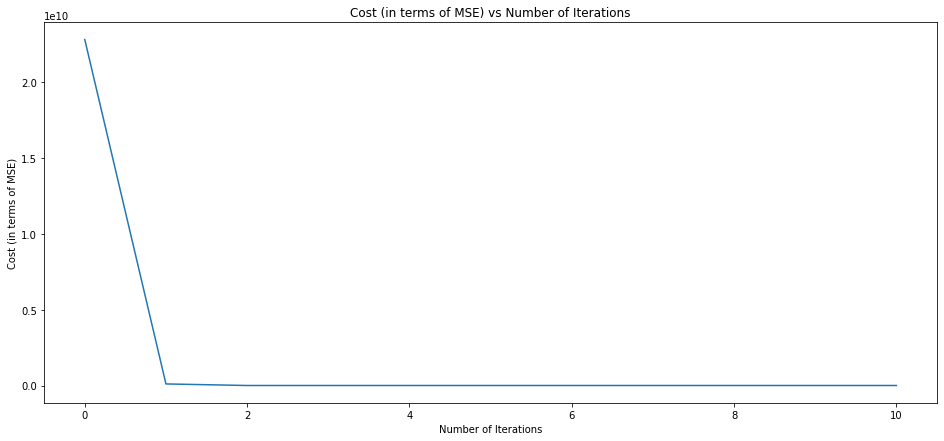

In [20]:
print("\nT_GT = ")
print(np.linalg.inv(K)@ P_gt)

P_op, Cost, it_conv = GN(P_init,img_h,points_h,1000,1e-4)
P_op = P_gt[-1,-1]*P_op/P_op[-1,-1] 

print("\nFinal MSE = ",Cost[it_conv])
print("\niterations to converge = ",it_conv+1)
print("\nP_Output = ")
print(P_op)
print("\nT_Output = ")
print(np.linalg.inv(K)@ P_op)

plt.figure(figsize=(16,7))
plt.plot(range(it_conv+1), Cost[0:it_conv+1])
plt.title('Cost (in terms of MSE) vs Number of Iterations')
plt.xlabel('Number of Iterations')
plt.ylabel('Cost (in terms of MSE)')

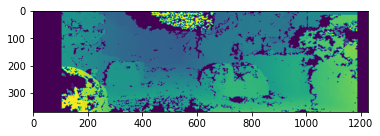

In [21]:
plt.imshow(disparity)
plt.show()

# Project 2 - Part B:

## 1. SfM pipeline (`6 mark`)

To get the context of below questions, take a look at the code above: The same questions have been asked at different places above as comments in the code.

1. `0.5 mark` **Basics** - How do we know this (`camera_ind`) information in practical setting? In other words, how do we know observations in `points_2d` belong to which camera. Explain. 
    - Ans-1 - Basics:
        - In practical settings, BA is the backend for SfM. On the frontend side, we have SIFT/SURF or ORB to find corresponding points in two images. Next 8 point algorithm estimates the Fundamental Matrix from which we can get the Essential Matrix and decompose them into R,t and K. Now we can triangulate points back to the world to 3D points. We know that images of different views are taken at different poses. Using this information, we can find out the pose from which the concerned image is taken as the output after SIFT/ORB, and hence find out which camera it corresponds to using camera_ind for each point in the image.
         
        
2. `0.5 mark` **Basics** - How do we know this (`point_ind`) information in practical setting?  In other words, how do we know observations in `points_2d` belong to which 3D point. Explain.
    - Ans-2 - Basics:
        - In practical settings, we know that images in different views are taken at different poses. Using this information, we have SIFT/SURF or ORB to find corresponding points between two images. Next 8 point algorithm estimates the Fundamental Matrix from which we can get the Essential Matrix and decompose them into R,t and K. Now we can triangulate or backproject points to the world to obtain 3D points.  Because of this, we now get our 2D-3D correspondences.
    
       
        
3. `0.5 mark` **Transformations** - `project()` function: In the `project()` function, would it make any difference if I do translate first, then rotate? Why/why not?
    - Ans-3 - Transformations:
        - Yes, there may be a difference. Translation before rotation implies that we're moving to a different origin first and rotating about that origin. Translating after rotating is moving the rotation center as well. 
        If the translation vector itself lies in the camera frame itself, it is necessary that the point be first rotated to the camera frame before it may be added to the translation vector since otherwise the translation vector and the point would lie in different frames.
        
        
4. `0.5 mark` **Jacobian** - `bundle_adjustment_sparsity()` function: m above is not "M*N" (*2) unlike our lecture notes. Why is that so?
    - Ans-4 - Jacobian:
    We know that each row of the Jacobian corresponds to a residual, we have as many rows as the no. of residuals. 
        - In our lecture notes, we used M for the number of images and N for the number of points in each image and we had MN 2D points, each giving 2 coordinates, so 2MN residuals for rows of the Jacobian. Here, since m contains the info about all the observations made together (all 2D points), i.e., `camera_indices.size` 2D points we have a different size for it. 
        
 
 
5. `2 mark` **Jacobian & Parameters** - `bundle_adjustment_sparsity()` function: 
    1.  Why are we doing `n_cameras * 9` here instead of `n_cameras * 12`? Recollect: Every individual motion Jacobian was (1*)12 in our lecture notes. 
        - Ans 5.1 - Jacobian & Parameters:
        
            - In class, we saw that the projection matrix is dependent on 12 parameters (since 3x4 matrix). In the above implementation, instead of having to use the elements of the projection matrix, we are using 3 translational parameters, 3 rotational parameters represented in `axis-angle form`, and 3 parameters for camera intrinsics, namely the focal length and 2 distortion parameters, to give a total of 9 parameters, and hence we are using `n_cameras * 9`.
                    
    2. Ignoring the scale parameters, what was the number of unknown parameters in our lecture notes in terms of `n_cameras` and `n_points`? What is it here in the code? Is it different? If so, what is and why? [Link of notes](https://www.notion.so/Stereo-Structure-from-Motion-9fdd81e4194f4803ac9ba7552df56470).
        - Ans 5.2 - Jacobian & Parameters:
            - In our lectures, number of unknown params was `(n_cameras * 12  + n_points * 3)`, where `n_points = (n_images x n_points_per_image)/n_times_every_point_is_seen)`
            - In the current implementation though, we are already given n_cameras and n_points, and the number of parameters required is also 9, so the total number of unknowns comes to `(n_cameras * 9 + n_points * 3)`


6. `2 mark` **Sparsity, Residual Vector & Jacobian** - `bundle_adjustment_sparsity()` function: Explain what you understand from above 6 lines of code by coding a simple toy example yourself to illustrate how it is different from what you've learnt in class. ([Coding toy example + elaborating in words]- both are compulsory.)
    - Ans 6 - Sparsity, Residual Vector & Jacobian: 
    In our Jacobian matrix, every row corresponds to a residual, every column is a parameter being optimized. There are `9* No of cameras` + `3* No. of world_pts` params, and hence columns. Each 2D point has 2 coordinates, (x and y) so there are twice as many residuals as no. of observations. For N points observed in M images, we had MN rows for the examples done in class, but here, we have `camera_ind.size` observations and twice as many rows. Also , in class the residuals were ordered first in the order of points, and then according to images, but here they appear in order particular order. 
    
    **Explanation of code**:
    The given code snippet marks the non-0 elements of the Jacobian, which allows Scipy solver to take advantage of the sparsity structure. `Numpy`'s integer array indexing sets to 1 all 9 cols for params of the corresponding camera for 2 rows of every observation. The next for loop sets 3 cols corresponding to the world point in the ith observation to 1 for all i. Other elements remain 0 and form a sparse structure. 
        


## 2. Initializing R,t and 3D points for SfM given 2 images (`4 mark`)

Using OpenCV functions, mention how you would initialize R,t (poses) and 3D points for SfM given 2 images and K matrix. You don't need to implement it, just mention function names with input/output arguments clearly and briefly explain what they do (You don't need to give detailed answers). A sample answer could be as follows:

**Ans 2:**

1. First we need to do feature matching. For this, we create an instance of ORB detector class of openCV using `cv2.ORB_create()` and use its `detectAndCompute()` function as a detector to extract ORB features (keypoints and descriptors) on both images. We pass None to show that we are not passing predefines features.
    - `orb = cv2.ORB_create()`
    - `kp1, des1 = orb.detectAndCompute(img1,None)`
    - `kp2, des2 = orb.detectAndCompute(img2,None)`
    
   So, now we have keypoints and descriptors corresponding to img1 and img2. 
2. Now, we need to match keypoints from the two images. For this, create a Brute-Force Matcher `bf = cv2.BFMatcher()`, and using the ORB descriptors, perform KNN matching using the knnMatch() function
    - `bf = cv2.BFMatcher()`
    - `matches = bf.knnMatch(des1,des2,k=2)`
   Alternately, we can use 
   
       `matches = bf.match(des1,des2)`. 
   
   Now we have matched features from both images.
    
3. Using these matches, we can find the fundamental matrix using the `cv2.finfFundamentalMat()` function.
    - Using other algorithms is also a viable option. For example, the normalized 8-pt algo.

4. After finding the fundamental matrix $F$, since we know $K$, we can find the essential matrix as $E = K^TFK$.

Alternately, we can combine the above 2 steps into:

`E = cv2.findEssentialMat(p1,p2,K)` to directly get the Essential Matrix.

5. From the above essential matrix $E$, we can decompose it into rotation and translation components $R$ and $t$ using 
`output = cv2.recoverPose(E,p0,p1,K)` which takes $E$, the matches(p1,p2) and calibration matrix $K$ as input and returns $R$ and $t$ as two of the many outputs. 

$R$ comes from output[1] and $t$ from output[2].

6. Using this information so far, we can use the 2D-2D correspondences (matches) and the above vectors and matrices to perform triangulation to get the 3D locations for SfM. This is to be achieved using 

`points_3d = cv2.triangulatePoints([p1,p2],output)`. This gives the 3D points as output.

